### Note
Perhaps it is best to link a google drive storage to this notebook. Downloading the model weights is time consuming and I'm afraid we may hit the colab disk threshold.

In [4]:
from PIL import Image
import torch
from tqdm.auto import tqdm
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from diffusers import StableDiffusionInpaintPipeline, DPMSolverMultistepScheduler

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

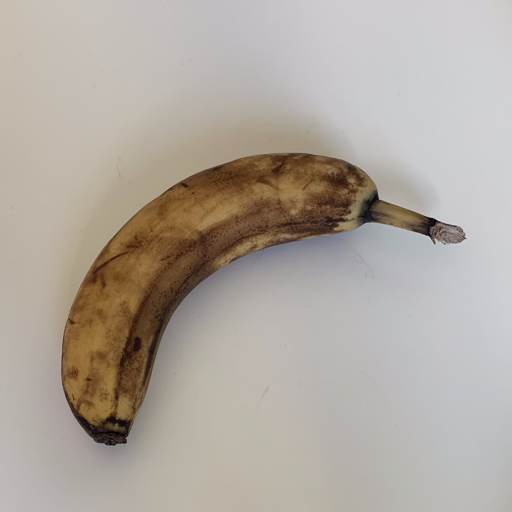

In [6]:
photo = Image.open("real_banana.png")
photo.resize((512, 512))

### point-diffusion

In [7]:
PILtoTensor = transforms.ToTensor()

In [8]:
from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud

Strange thing: even though the num. tokens is changed, the transformer still loads the pre-trained weights and it also accepts inputs with a different number of tokens.

In [9]:
base_name = 'base300M' # base40M, use base300M or base1B for better results

MODEL_CONFIGS[base_name]["n_views"] = 1
MODEL_CONFIGS['upsample']["n_views"] = 1

print('creating base model...')
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

creating base model...
[-] Low Res Diff Transformer set with 1024+256*1 input tokens.
creating upsample model...
[-] High Res Diff Transformer set with 3072+256*1 input tokens.
downloading base checkpoint...
downloading upsampler checkpoint...


<All keys matched successfully>

In [11]:
sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096-1024], # points in cloud and missing ones for upsampling
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 3.0],
)

In [13]:
# Produce a sample from the model.
samples = None
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(images=[photo]))):
    samples = x

0it [00:00, ?it/s]

In [14]:
samples.shape

torch.Size([1, 6, 4096])

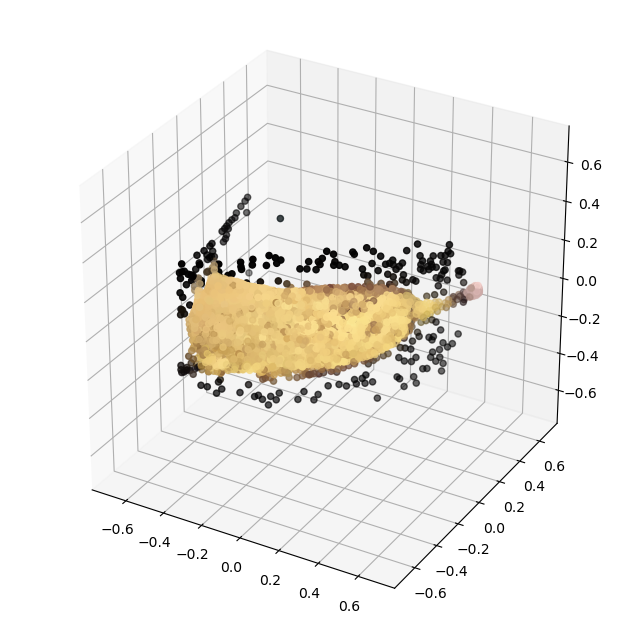

In [16]:
pc = sampler.output_to_point_clouds(samples)[0]
fig = plot_point_cloud(pc, grid_size=1, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))